# Libraries

In [1]:
import pandas 			 as pd
import numpy 			 as np
import matplotlib.pyplot as plt

import scipy.signal as signal

from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics 		 import r2_score
from sklearn.linear_model 	 import LinearRegression

import joblib


# ECG Definitions

ECG file headers

In [2]:
ecgHeaders = [
	"sample",
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ECG plot definitions

In [3]:
ecgPlotHeaders = [
    "LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI":   "seagreen",
	"aVR":  "black",
	"V1":   "gold",
	"V4":   "orangered",
	"LII":  "cornflowerblue",
	"aVL":  "seagreen",
	"V2":   "gold",
	"V5":   "crimson",
	"LIII": "cornflowerblue",
	"aVF":  "cornflowerblue",
	"V3":   "orangered",
	"V6":   "crimson"
}

Loading ECGs labeled as acceptable

In [4]:
ecgsDataset = []

with open("../../../data/labels/RECORDS-acceptable") as file:
	ecgsDataset = map(
		lambda ecgName: ecgName.strip(), 
		file.readlines()
	)
	ecgsDataset = list(ecgsDataset) 

	print("Dataset len =", len(ecgsDataset))

Dataset len = 773


Split dataset

In [5]:
trainEcgs, validationEcgs = train_test_split(
	ecgsDataset, 
	train_size = .70, 
	test_size = .30
)

print("Train dataset len =",     len(trainEcgs))
print("Validation dataset le =", len(validationEcgs))

Train dataset len = 541
Validation dataset le = 232


# Linear Regression Definitions

Features Vector

In [6]:
ecgFeatures = [
	"LII", 
	"Z"  , # Z = -0,5 * V2 
	"V6" , 
]

Target Vector

In [7]:
ecgTarget = [
	"LI", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V3",
	"V4",
	"V5",
]

# Preprocessing Dataset

ECG preprocessing function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $N = 500 $ samples
- With 5 Gain

In [8]:
order = 2
fc    = 1
fs    = 500

b, a = signal.butter(
	N 	  = order,
	Wn 	  = fc,
	btype = "highpass",
	fs 	  = fs
)

print("Numerator: ",   b)
print("Denominator: ", a)

Numerator:  [ 0.9911536  -1.98230719  0.9911536 ]
Denominator:  [ 1.         -1.98222893  0.98238545]


In [9]:
def preprocessing(ecgDf):
	ecgClean      = ecgDf.apply(
		lambda column: 5 * signal.filtfilt(b, a, column), 
		axis = 0
	)
	ecgClean      = ecgClean.iloc[500: -500]
	ecgClean["Z"] = -0.5 * ecgClean["V2"]

	return ecgClean

Load and preprocessing dataset

In [10]:
xTrainAll = []
yTrainAll = []

for trainEcgFile in trainEcgs:
	ecg = pd.read_csv(
		filepath_or_buffer = f"../../../data/set-a/{trainEcgFile}.txt",
		names = ecgHeaders,
		index_col = 0
	)

	ecgClean = preprocessing(ecg)
	
	xTrain = ecgClean[ecgFeatures]
	yTrain = ecgClean[ecgTarget]
	
	xTrainAll.extend(xTrain.values)
	yTrainAll.extend(yTrain.values)

In [11]:
xValidationAll = []
yValidationAll = []

for validationEcgFile in validationEcgs:
	ecg = pd.read_csv(
		filepath_or_buffer = f"../../../data/set-a/{validationEcgFile}.txt",
		names = ecgHeaders,
		index_col = 0
	)

	ecgClean = preprocessing(ecg)

	xValidation = ecgClean[ecgFeatures]
	yValidation = ecgClean[ecgTarget]

	xValidationAll.extend(xValidation.values)
	yValidationAll.extend(yValidation.values)

Normalization

In [12]:
scaler = StandardScaler()

In [13]:
xTrainScaled      = scaler.fit_transform(xTrainAll)
xValidationScaled = scaler.transform(xValidationAll)

# Training

In [14]:
linearModel = LinearRegression()

In [15]:
linearModel.fit(xTrainScaled, yTrainAll)

LinearRegression()

In [16]:
print("Coefficients: ")
print(np.round(linearModel.coef_, 3))
print(np.round(linearModel.intercept_, 3))

Coefficients: 
[[  54.702   18.315   11.968]
 [  84.47   -18.315  -11.968]
 [ -96.433   -9.171   -5.969]
 [ 111.532   -9.167   -6.028]
 [ -15.426   18.358   11.978]
 [ -60.11   -99.128  -12.597]
 [  67.65  -123.684   -4.671]
 [ 125.748  -63.632   20.38 ]
 [ 123.767  -15.231   34.816]]
[ 0.061 -0.123 -0.    -0.092  0.093 -0.196  0.741 -0.188  0.152]


# Validation

In [17]:
yPredicted = linearModel.predict(xValidationScaled)

rmseValidation = r2_score(
	y_true 		= yValidationAll, 
	y_pred 		= yPredicted,
	multioutput = "raw_values"
)
rmseValidation = np.round(rmseValidation, 3)
rmseValidation = rmseValidation.tolist()

rmseScores = pd.DataFrame(
    columns = ecgTarget,
    data    = [rmseValidation]
)

print(rmseScores)

      LI  LIII    aVR   aVL   aVF     V1     V3     V4     V5
0  0.216  0.22  0.742  0.74 -0.05  0.007  0.429  0.028  0.077


# Ploting

In [18]:
def plotECG(ecg, headers, colors): 
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		axes[idx].plot(ecg[header], color = colors[header])
		axes[idx].set_title(f"{header}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [19]:
def comparativeFullEcgPlot(ecgOring, ecgRec, headers):
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("Comparison: ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		corr = np.round(ecgOring[header].corr(ecgRec[header]), 3)
		r2   = np.round(r2_score(ecgOring[header], ecgRec[header]), 3)

		axes[idx].plot(
			ecgOring[header], 
			color = "blue", 
			alpha = 0.75
		)
		axes[idx].plot(
			ecgRec[header], 
			color = "red", 
			alpha = 0.75
		)

		axes[idx].set_title(f"{header} CORR = {corr} R2 = {r2}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

Loading a ECG sample for reconstruction

In [20]:
ecgSampleDf = pd.read_csv(
	filepath_or_buffer = f"../../../samples/1002867.txt",
	names 			   = ecgHeaders,
	index_col 		   = 0
)

In [21]:
ecgSampleDf = preprocessing(ecgSampleDf)

Trying to reconstruct the ECG

In [22]:
xFeaturesSampleEcgDf = ecgSampleDf[ecgFeatures]
yTargetSampleEcg = ecgSampleDf[ecgTarget].values

ecgSampleTargetPredicted = linearModel.predict(
	X = scaler.transform(
		X = xFeaturesSampleEcgDf.values
	)
)

In [23]:
ecgSampleTargetPredictedDf = pd.DataFrame(
	data    = ecgSampleTargetPredicted,
	columns = ecgTarget,
	index   = ecgSampleDf.index
)

In [24]:
ecgSampleRecDf = pd.concat([
	xFeaturesSampleEcgDf,
	ecgSampleTargetPredictedDf     
], axis = 1)


In [25]:
ecgSampleRecDf["V2"] = ecgSampleDf["V2"]

Comparison between original and reconstructed ECG

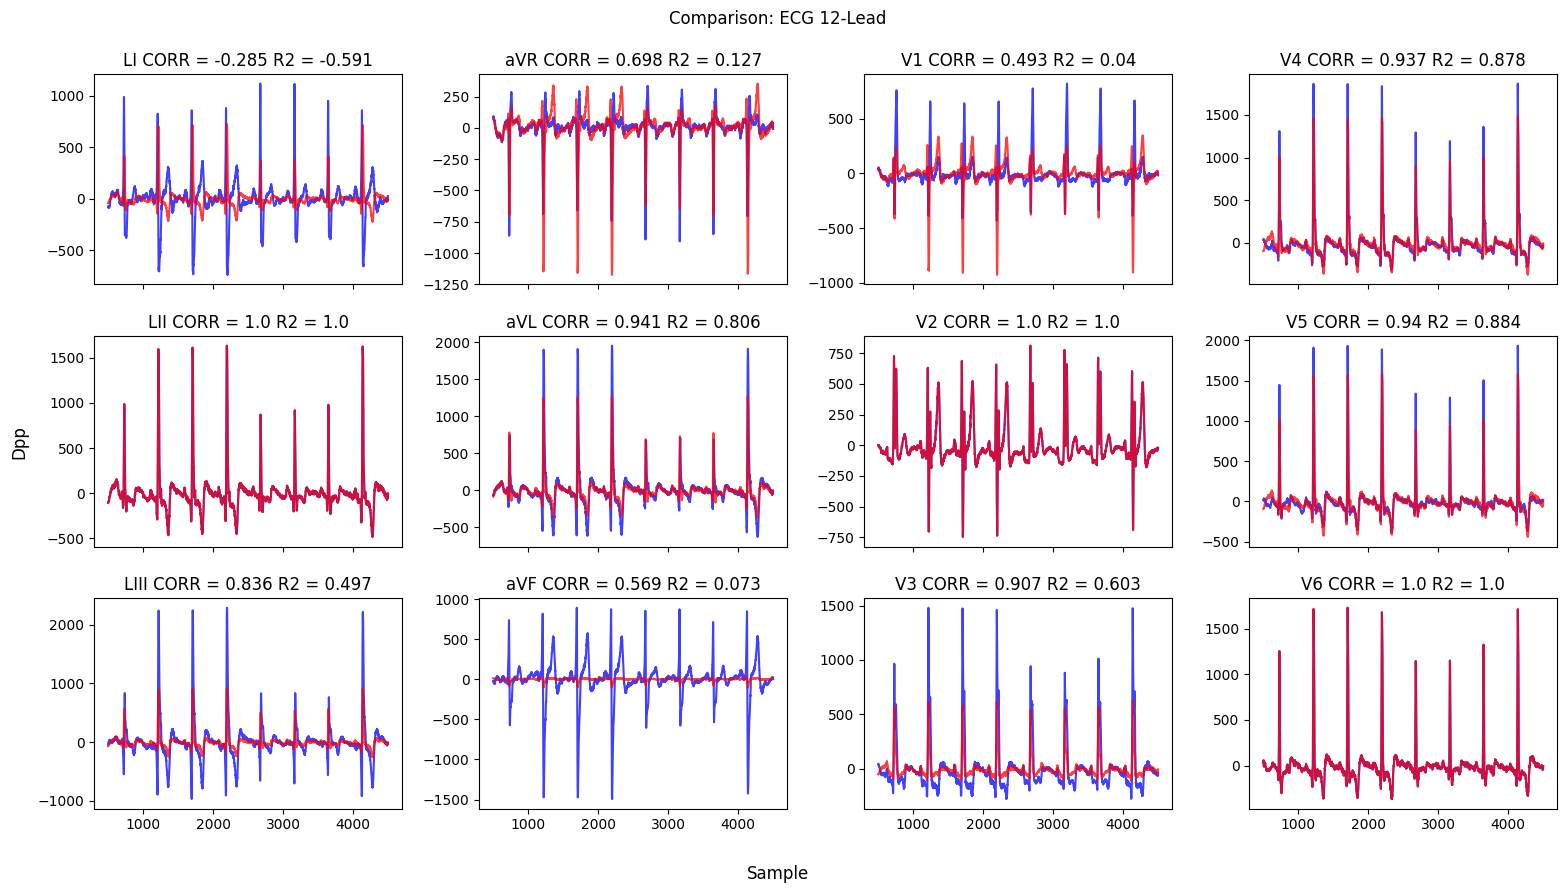

In [26]:
comparativeFullEcgPlot(
	ecgOring = ecgSampleDf,
	ecgRec   = ecgSampleRecDf,
    headers  = ecgPlotHeaders
)

Seeing a strip of reconstruction

In [27]:
viewport = slice(1000, 1500)

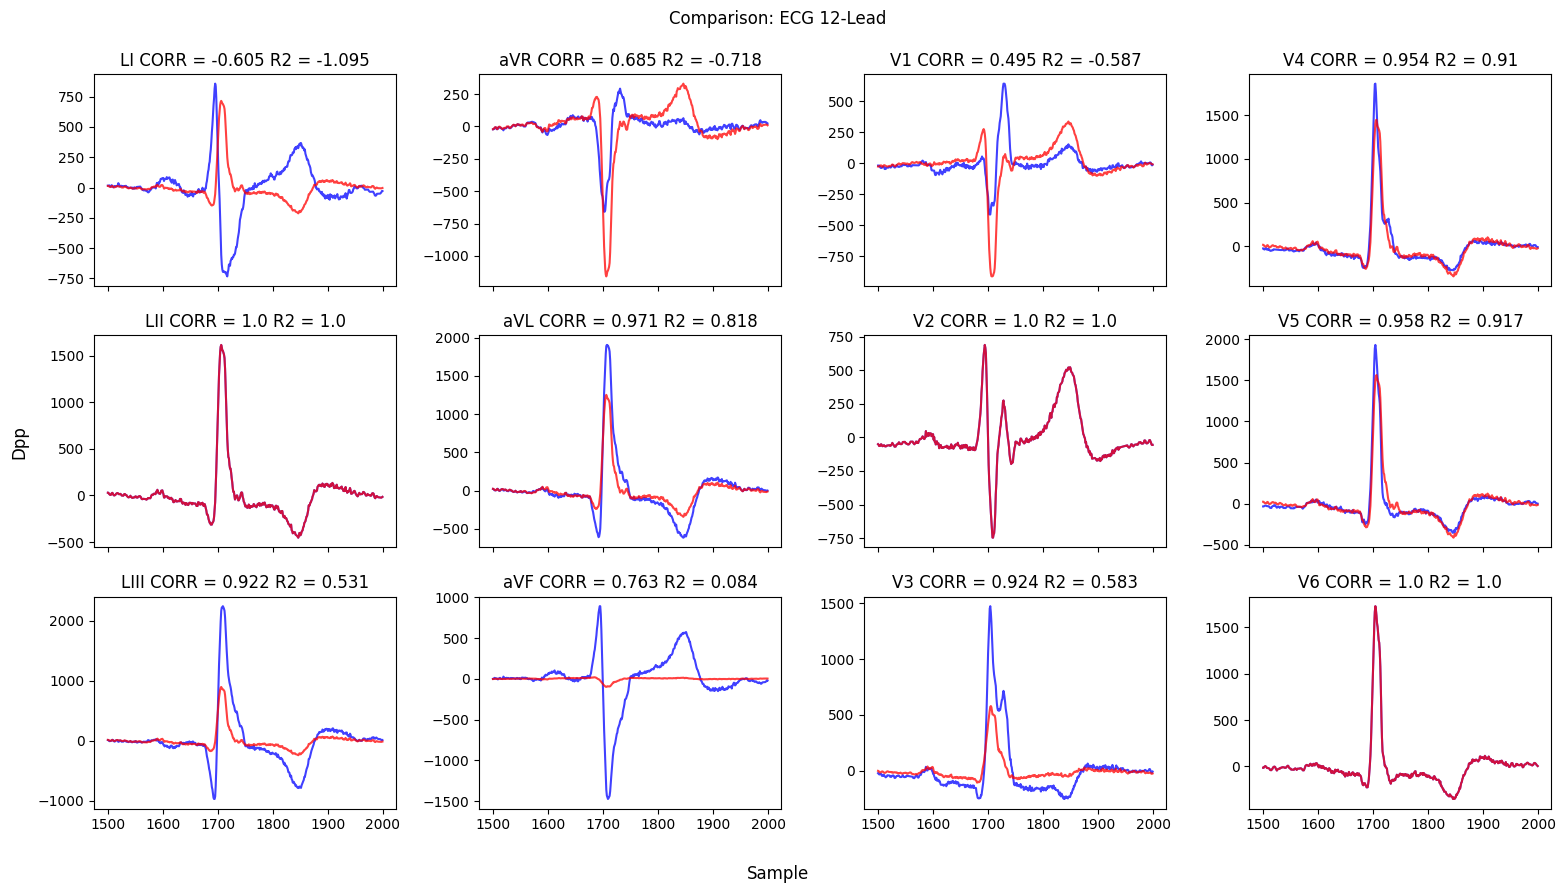

In [28]:
comparativeFullEcgPlot(
	ecgOring = ecgSampleDf[viewport],
	ecgRec   = ecgSampleRecDf[viewport],
    headers  = ecgPlotHeaders
)

# Save Model

In [29]:
joblib.dump(
	value    = linearModel,
	filename = "../../../models/t1/reglin-t1-v0.pkl"
)

joblib.dump(
	value    = scaler,
	filename = "../../../models/t1/reglin-t1-v0.scaler.pkl"
)

['../../../models/t1/reglin-t1-v0.scaler.pkl']